In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [4]:
import requests

url = "https://www.openml.org/data/download/22102255/dataset"
r = requests.get(url, allow_redirects=True)

with open('../data/dataset.txt', 'wb') as f:
    f.write(r.content)

In [ ]:
data = []

with open('../data/dataset.txt', 'r') as f:
    for line in f.read().split('\n'):
        if line.startswith('@') or line.startswith('%') or line == "":
            continue
        data.append(line)
        
        
columns = []

with open('../data/dataset.txt', 'r') as f:
    for line in f.read().split('\n'):
        if line.startswith('@ATTRIBUTE'):
           columns.append( line.split(' ')[1] )
           
           
with open('../data/df.csv', 'w') as f:
    f.write(",".join(columns))
    f.write('\n')
    f.write('\n'.join(data))

In [ ]:
df_raw = pd.read_csv('../data/df.csv')
df_raw.columns = columns

df1 = df_raw.copy()

In [ ]:
df1['t_win'] = df1['round_winner'].astype('category').cat.codes

In [ ]:
correlations = df1.corr(numeric_only=True)['t_win'].apply(abs).sort_values(ascending=False)
best_correlations = list( correlations[:21].index )

In [ ]:
correlations[:21]

t_win                           1.000000
ct_armor                        0.336382
ct_helmets                      0.308255
t_helmets                       0.297458
ct_defuse_kits                  0.291557
t_armor                         0.290753
ct_grenade_flashbang            0.253868
ct_players_alive                0.216798
ct_grenade_smokegrenade         0.209975
ct_weapon_awp                   0.198626
t_weapon_ak47                   0.194147
ct_health                       0.190662
bomb_planted                    0.187101
ct_weapon_m4a4                  0.178008
ct_grenade_hegrenade            0.168781
ct_grenade_incendiarygrenade    0.168517
ct_weapon_ak47                  0.166855
t_grenade_flashbang             0.166839
ct_weapon_sg553                 0.163963
t_weapon_sg553                  0.163709
ct_weapon_usps                  0.152893
Name: t_win, dtype: float64

<Axes: >

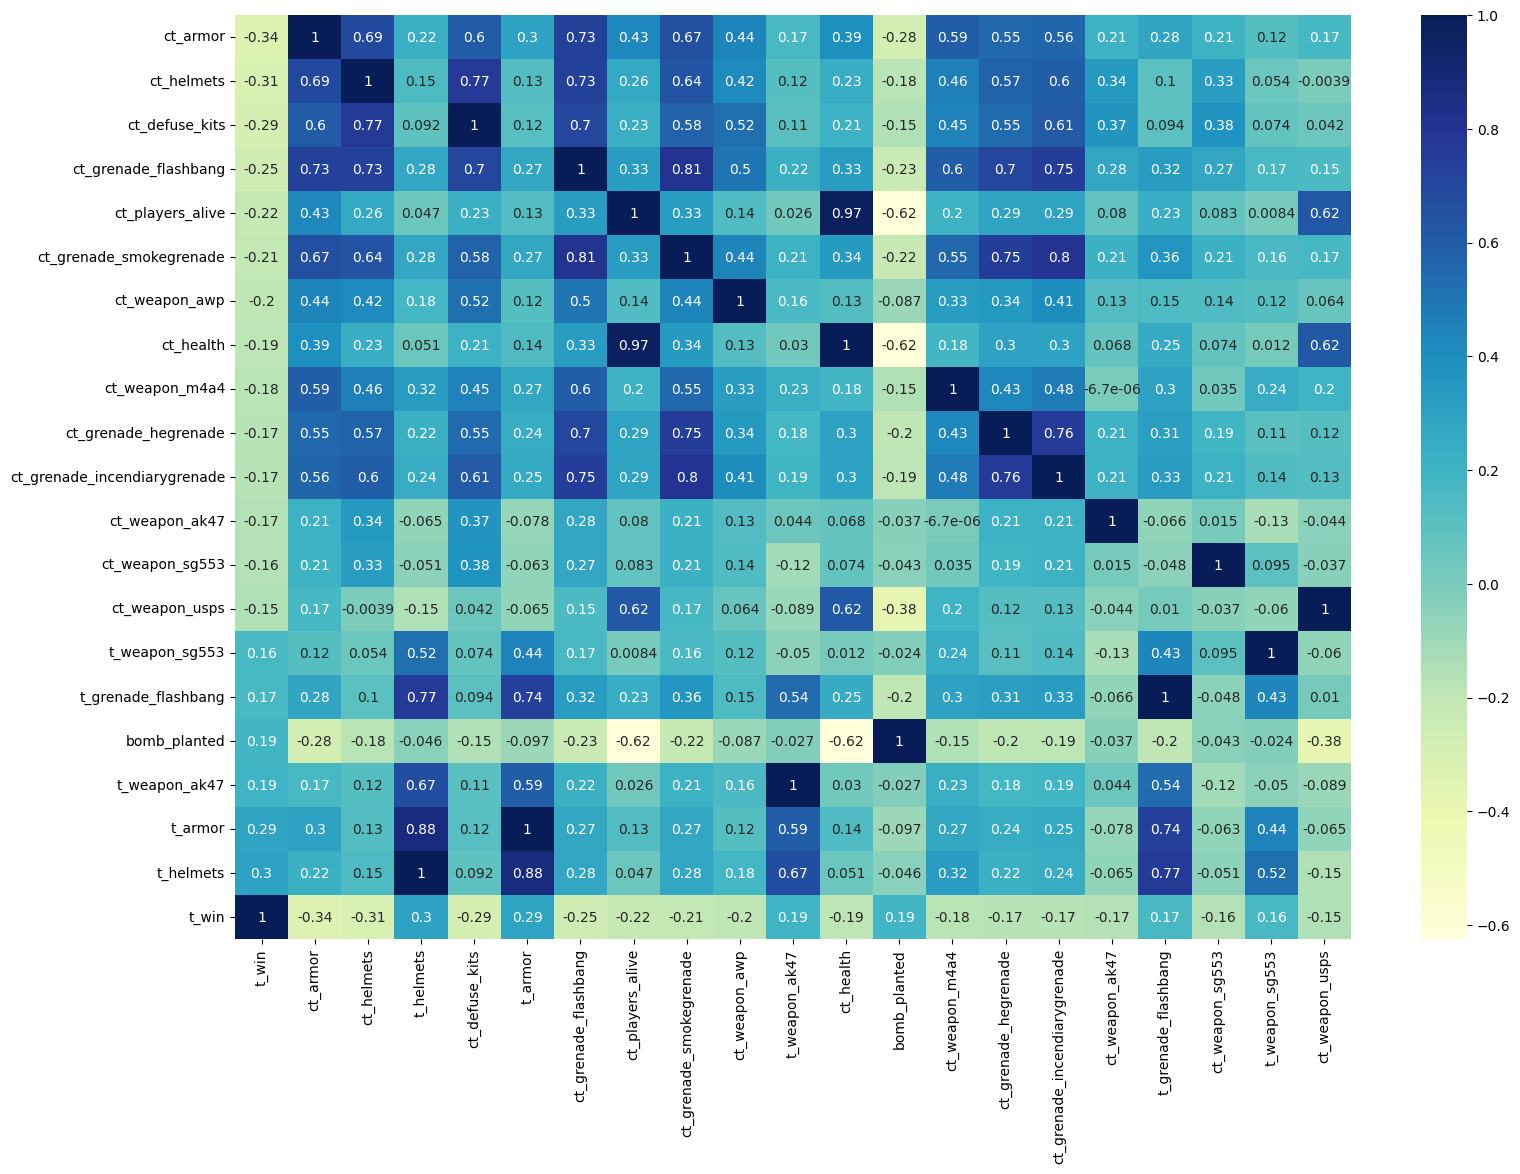

In [ ]:
best_correlations_df = df1[best_correlations]
plt.figure(figsize=(18,12))
sns.heatmap(best_correlations_df.corr().sort_values('t_win'), annot=True, cmap='YlGnBu')

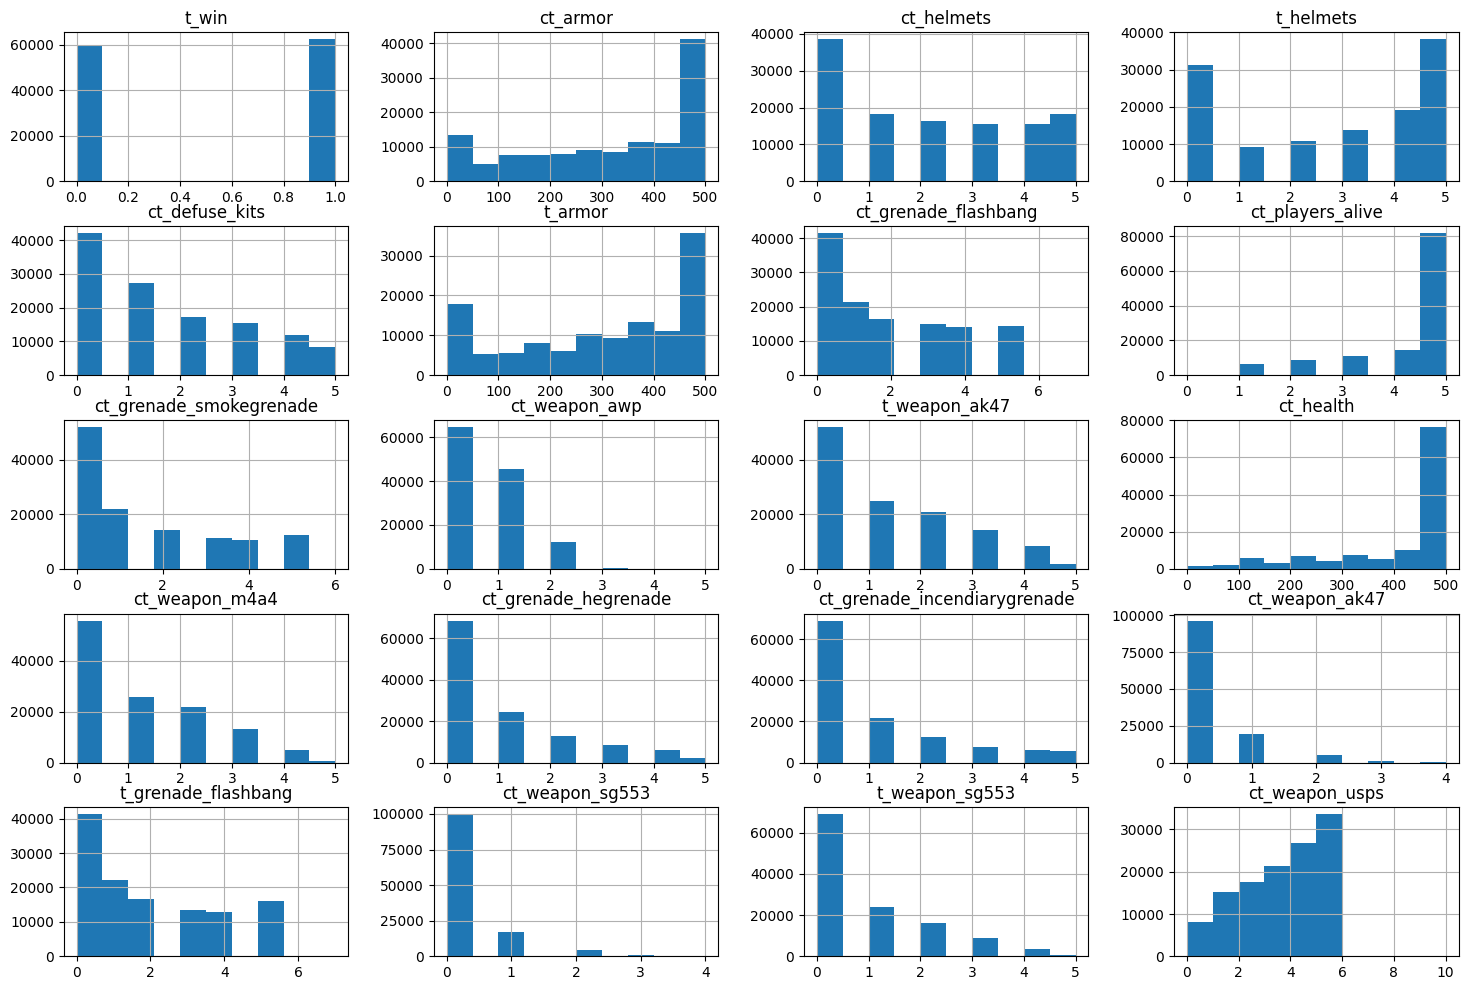

In [ ]:
best_correlations_df.hist(figsize=(18,12));

In [ ]:
scaler = StandardScaler()

x, y = best_correlations_df.drop('t_win', axis=1), best_correlations_df['t_win']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [ ]:
knn = KNeighborsClassifier()

knn.fit(x_train_scaled, y_train)
y_hat_knn = knn.predict(x_test_scaled)

score = knn.score(x_test_scaled, y_test)
print('Score for KNN default settings: {}'.format(score))

Score for KNN default settings: 0.7655828772159138


In [ ]:
param_grid = {
             'n_neighbors': list(range(5,17,2)),
             'weights': ['uniform', 'distance']
}

knn = KNeighborsClassifier()

classifier = RandomizedSearchCV(knn, param_grid, n_iter=3, verbose=2, cv=3, random_state=42)
classifier.fit(x_train_scaled, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ....................n_neighbors=15, weights=uniform; total time=   3.9s
[CV] END ....................n_neighbors=15, weights=uniform; total time=   4.2s
[CV] END ....................n_neighbors=15, weights=uniform; total time=   4.7s
[CV] END ...................n_neighbors=13, weights=distance; total time=   5.0s
[CV] END ...................n_neighbors=13, weights=distance; total time=   5.0s
[CV] END ...................n_neighbors=13, weights=distance; total time=   6.4s
[CV] END .....................n_neighbors=5, weights=uniform; total time=   8.8s
[CV] END .....................n_neighbors=5, weights=uniform; total time=   7.3s
[CV] END .....................n_neighbors=5, weights=uniform; total time=   5.4s


RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_iter=3,
                   param_distributions={'n_neighbors': [5, 7, 9, 11, 13, 15],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, verbose=2)

In [ ]:
knn_best_grid = classifier.best_estimator_
knn_best_grid.score(x_test_scaled, y_test)

0.7805734825586145

In [ ]:
param_grid = {
                'n_estimators': list(range(100, 500, 100))
}

forest = RandomForestClassifier()

classifier = RandomizedSearchCV(forest, param_grid, n_iter=3, verbose=2, cv=3, random_state=42)
classifier.fit(x_train_scaled, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ...................................n_estimators=200; total time=  26.7s
[CV] END ...................................n_estimators=200; total time=  26.8s
[CV] END ...................................n_estimators=200; total time=  26.4s
[CV] END ...................................n_estimators=400; total time=  53.4s
[CV] END ...................................n_estimators=400; total time=  56.7s
[CV] END ...................................n_estimators=400; total time= 1.0min
[CV] END ...................................n_estimators=100; total time=  15.1s
[CV] END ...................................n_estimators=100; total time=  13.9s
[CV] END ...................................n_estimators=100; total time=  17.0s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=3,
                   param_distributions={'n_estimators': [100, 200, 300, 400]},
                   random_state=42, verbose=2)

In [ ]:
forest_best_grid = classifier.best_estimator_
forest_best_grid.score(x_test_scaled, y_test)

0.8324483293848541

In [ ]:
forest_simple = RandomForestClassifier()

forest_simple.fit(x_train_scaled, y_train)
forest_simple.score(x_test_scaled, y_test)

0.8298341638755004